<a href="https://colab.research.google.com/github/jefe-jeff/rl_electrical_stim/blob/main/cs238_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# The math of it all


What do we need?

We need to be able to define each of the state spaces, the action space, the 
transition probabilities, and the reward function. The reward function is how 
we implement the practical constraints of the system, and when outlawed actions
are taken we can aggressively change the score and keep track of the number of 
penalties. 

The state space has three components:
  - The pixel mean space, $S_\mu$, a 40 x 80 pixel grid
  - The pixel variance space, $S_{\sigma^2}$, a 40 x 80 pixel grid
  - The electrode space, $S_e$, a 512 dimensional vector

The action space has three components:
  - The stimulating electrode, $p$
  - The stimulation amplitude, $q$
  - The cell flags, $f = \{0, 1\}^{|((p,q))|}$, where $((p, q))$ indicates a list of cells with a nonzero reponse probability to $(p,q)$

We need to define some easy functions:
  - $CP(c)$ maps cell $c \in ((p,q))$ to its normalized STA (pixel space) (called 'decoder' in code)
  - $CT(c)$ maps cell $c \in ((p,q))$ to its type (+1 if ON cell, -1 if OFF cell) (called 'polarity' in code)
  - $P(c | p, q)$ maps cell $c \in ((p,q))$ and $(p,q)$ to the cells response probability, given $(p,q)$
  -$REOC(c)$ maps the cell $c \in ((p,q))$ to the electrodes that pick up significant signal from  $c$. (REOC = Recording Electrodes on Cell)
  -$SEOC(c)$ maps the cell $c \in ((p,q))$ to all electrodes that have a nonzero probaility of stimulating $c$. (SEOC = Stimulating Electrodes on Cell)

The transition probabilities $T(s'|s, (p, q, f))$ are defined in the following 
way, split up to reflect the conditional independence of transition on each of 
the tree joint state spaces.
  - $T(s'| s, (p, q, 0)) = 0$ or $1$, i.e. is deterministic
  - With probability 1, $s$ transitions to $s'$ via (p, q, 0) in the following way
    - $s'_\mu = s_\mu -  \sum_{c \in ((p,q))} CT(c)CP(c)P(c | p, q)$
      
      There is a stipulation that the final value for a pixel in $s_\mu$
      must be zero or match the sign of the $CT(c)$ i.e. ON cells can't make a pixel negative and OFF cells can't make a pixel postive.
    - $s'_{\sigma^2} = s_{\sigma^2} +  \sum_{c \in ((p,q))} CP(c)P(c | p, q)(1-P(c | p, q))$
    - $s'_e = \max(s_e - 1, 0) + \tau_r \cup_{c \in ((p,q))}SEOC(c)$, where $t_r$ is the number of steps according to the refractory period. Check the ACF plots to get the appropriate delays. *DECIDE WHETHER OR NOT SHOULD BE CUSTOM TO CELLS*
  - $T(s'| s, (p, q, 1)) \in [0, 1]$ i.e. is stochastic
    - $s'_\mu = s_\mu -  \sum_{c \in ((p,q))} CT(c)CP(c)F_c, F_c \sim Ber(P(c | p, q))$
    - $s'_{\sigma^2} = s_{\sigma^2}$
    - $s'_e = \max(s_e - 1, 0) + \tau_d \cup_{c \in ((p,q))}REOC(c)$, where $t_D$ is the number of steps according to the spike detector delay time. Delay time range 60-120 samples, 80 samples on average -> 4 ms
    
The reward function $R(s', s)$ I think is also decomposable into three parts $R_\mu, R_{\sigma^2}, R_e$
  - $R_\mu(s') = - \Vert s'_\mu\Vert_2^2$
  - $R_{\sigma^2}(s') = - \Vert s'_{\sigma^2}\Vert_1$
  - $R_e(s', s) = -1[\Vert s'_e1[s_e] - s_e \Vert_\infty > 0]$
  - $R(s', s) = \lambda_\mu R_\mu(s') + \lambda_{\sigma^2}R_{\sigma^2}(s') + \lambda_e R_e(s', s)$

Expectations:
1. For very large $\lambda_{\sigma^2}$, the agent will be driven use 'detectors' - the agent will hate indeterminate spikes.
2. For very large $\lambda_e$, the won't choose electrodes that violate constraints.
3. For small $\lambda_e$, the agent will probably choose to flag every cell - minimize variance 

Questions for Nishal

How are the normalized STA response explicitly computed?

How can I get the dictionary that was used in the original greedy algorithm?

Choose the subset of electrodes that maximize SNR?
 Sasi's project on refractory 

 Ask sreela about spike sorting penalty




For electrode space, parameterize the state space by taking a boolean vector, comparing to action, and then the Q value is litterally negative infinity or 0. Easy!

For the pixel $\mu$ space



In [38]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from google.colab import files
import utils

In [39]:
datapath = '/content/drive/Shared drives/CS238 Project/data/'
imagepath = '/content/drive/Shared drives/CS238 Project/img/'
dataset = '2012-09-24-3'

In [8]:
simulation_details = sio.loadmat(datapath + dataset + '/stimulation_results_detail_fr_3.3_greedy.mat')
dictionary = simulation_details['dictionary_final']
decoder = simulation_details['decoder']
targets = simulation_details['targets']

num_cells = decoder.shape[1]

In [ ]:
on_decoder, off_decoder, polarity = utils.compute_polarity(decoder)

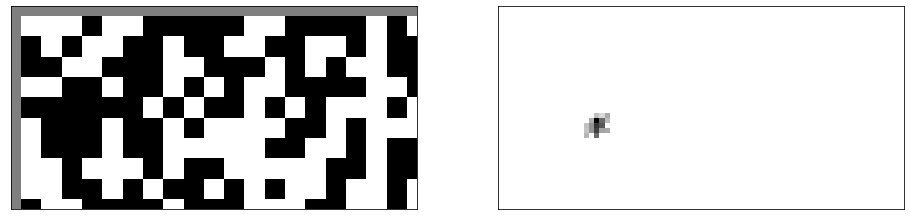

In [ ]:
plt.figure(num=None, figsize=(16, 12))
target = 0
cell = 105
ax = plt.subplot(121)
ax.imshow(targets[:,target].reshape((40,80)), cmap = 'gray')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

ax2 = plt.subplot(122)
ax2.imshow(decoder[:,cell].reshape((40,80)), cmap = 'gray')
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

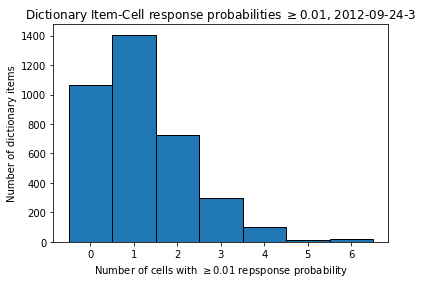

In [40]:
hist = plt.figure()
plt.hist(np.sum(dictionary >= 0.01, axis =1), bins = 7, range = (-0.5, 6.5), edgecolor = 'k')
plt.title('Dictionary Item-Cell response probabilities $\geq 0.01$, %s' %dataset)
plt.xlabel('Number of cells with $\geq 0.01$ repsponse probability')
plt.ylabel('Number of dictionary items')

hist.show()

hist.savefig(imagepath + 'dictionary_cellnum_hist.png')
files.download(imagepath +'dictionary_cellnum_hist.png')

The distribution of cell stimulation does a lot to confine our action space. 1406 dictionary elements stimulate 1 cell >= 0.01; 726 for 2 cells; 299 for 3 cells; 98 for 4 cells; 9 for 5 cells; 18 for 6 cells. 

According to the rules we have so far, that is 2 * 1406  + 4 * 726 + 8 * 299 + 16 * 98 + 32 *5 + 64 * 18 = 10988. Now, that's a lot of actions. It's unclear how to scale the power function with the number of flagged cells and whether all the cells are able to be discrminated when there are too many.

In [47]:
np.sum(np.sum(dictionary >= 0.01, axis =1) == 6)

18